In [1]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools
from snntorch import utils
from snntorch import spikegen

DVS data

In [2]:
from src.io.psee_loader import PSEELoader

import pathlib
from glob import glob

device = 'cpu'

delta_t = 1000
n = 75
skip = 100
n_in = 30

vids = map(PSEELoader, glob("Prophesee_Dataset_n_cars/n-cars_train/cars/*_td.dat"))
# height, width = vid.get_size()
height, width = 120, 120
# vid.seek_time(skip)
event_seqs = [next(vids).load_delta_t(delta_t) for _ in range(n)]
# N = len(event_seqs)

#print(event_seqs[0])

dat = np.zeros((n, delta_t, 30, 30),dtype=np.int8)
for i,block in enumerate(event_seqs):
    for ev in block:
        dat[i,ev[0],ev[1]//4,ev[2]//4] = ev[3]
# for ev in events:
#     dat[ev[0],ev[1],ev[2]] = ev[3]

# dat = decimate(dat,4,axis=2)
# dat = decimate(dat,4,axis=3)

train_data = dat[0:60,:,:,:]
test_data  = dat[60:75,:,:,:]

train_data = train_data.reshape((train_data.shape[0], train_data.shape[1], -1))
test_data = test_data.reshape((test_data.shape[0], test_data.shape[1], -1))

print(train_data.shape, test_data.shape)

(60, 1000, 900) (15, 1000, 900)


In [35]:
batch_size = 8
data_path='/data/mnist'
num_steps=1000
n_in = 30

class RegressionDataset(Dataset):
    def __init__(self, x,y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

train_loader = DataLoader(RegressionDataset(train_data, train_data), batch_size=batch_size)
test_loader  = DataLoader(RegressionDataset(test_data, test_data),  batch_size=batch_size)


In [36]:
# Network Architecture
num_inputs = n_in*n_in
num_hidden = 1000
num_outputs = n_in*n_in

# Temporal Dynamics
num_steps = 1000
beta = 0.95

# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            print(step)
            cur1 = self.fc1(x[step].float())
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
        #print(torch.stack(spk2_rec, dim=0))

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
net = Net().to(device)

In [6]:
def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    targets = targets.view(batch_size,-1).numpy()
    #_, idx = output.sum(dim=0).max(1)
    #_, idx = output.sum(dim=0).max(1)
    #acc = np.mean((targets == idx).detach().cpu().numpy())
    #print('op',output.shape, targets.shape)
    avg_rate_output = output.mean(axis=0).detach().numpy()
    acc = np.mean((avg_rate_output - targets)**2)

    #acc = np.mean((targets - idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc}")
    else:
        print(f"Test set accuracy for a single minibatch: {acc}")

def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [29]:
loss = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

In [30]:
num_steps=1000

data, targets = next(iter(train_loader))
data = data.view(num_steps, batch_size, -1).to(device)
targets = data.view(num_steps, batch_size, -1).to(device)

print(data.shape, targets.shape)

spk_rec, mem_rec = net(data.view(num_steps, batch_size, -1))
print(spk_rec.size(), mem_rec.size())

# initialize the total loss value
#loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

torch.Size([1000, 16, 900]) torch.Size([1000, 16, 900])
torch.Size([1000, 16, 900]) torch.Size([1000, 16, 900])


/home/karthik/miniconda3/envs/neuromorphic/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1000, 16, 900])) that is different to the input size (torch.Size([16, 900])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: 

In [31]:
# clear previously stored gradients
optimizer.zero_grad()

# calculate the gradients
loss_val.backward()

# weight update
optimizer.step()

RuntimeError: Found dtype Char but expected Float

In [37]:
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = data.to(device)#targets.to(device)
        targets = targets.squeeze(1).view(num_steps,batch_size, -1).float().mean(axis=0)

        spike_data = data

        # Spiking Data
        #spike_data = spikegen.rate(data, num_steps=num_steps)
        #print(spike_data.shape)

        #print(targets.shape)

        # forward pass
        print(spike_data.view(num_steps,batch_size, -1).shape)
        net.train()
        spk_rec, mem_rec = net(spike_data.view(num_steps,batch_size, -1))

        print(spk_rec.shape, targets.shape)

        #print(spk_rec.shape, mem_rec.shape, data.shape, targets.shape)

        # initialize the loss & sum over time
        #loss_val = torch.zeros((1), dtype=dtype, device=device)
        loss_val = loss(spk_rec.mean(axis=0), targets.view(batch_size,-1))
        #for step in range(num_steps):
            #loss_val += loss(spk_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_data.to(device)#test_targets.to(device)
            test_targets = test_targets.view(num_steps,batch_size, -1).float().mean(axis=0)

            spike_data_test = test_data

            #spike_data_test = spikegen.rate(data, num_steps=num_steps)

            # Test set forward pass
            test_spk, test_mem = net(spike_data_test.view(num_steps, batch_size, -1))

            # Test set loss
            #test_loss = torch.zeros((1), dtype=dtype, device=device)
            test_loss = loss(test_spk.mean(axis=0), test_targets.view(batch_size,-1))
            #for step in range(num_steps):
                #test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            '''if counter % 50 == 0:
                train_printer()'''
            counter += 1
            iter_counter +=1

torch.Size([1000, 8, 900])
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270

RuntimeError: mat1 and mat2 shapes cannot be multiplied (8x450 and 900x1000)

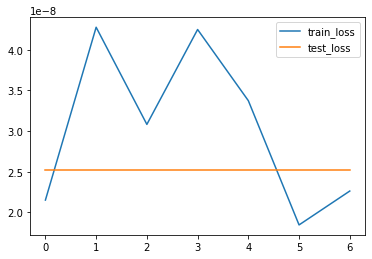

In [38]:
plt.figure()
plt.plot(loss_hist, label='train_loss')
plt.plot(test_loss_hist, label='test_loss')
plt.legend()

torch.Size([8, 1000, 900])
torch.Size([8, 1000, 900])
torch.Size([8, 1000, 900])
torch.Size([8, 1000, 900])


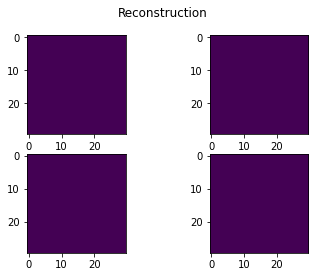

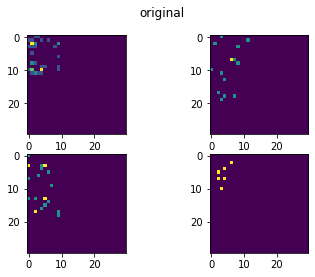

In [26]:
test_data, test_targets = next(iter(test_loader))

plt.figure()
for i in range(4):
    # Integrate through time for each location while displaying final image
    dat = test_data[i,:]
    print(test_data.shape)
    #dat = spikegen.rate(dat, num_steps=num_steps)
    spk_rec, mem_rec = net(dat.view(num_steps, 1, -1))
    final_image = spk_rec.sum(0)[0].detach().numpy()
    #plt.figure()
    plt.subplot(2,2,i+1)
    plt.imshow(final_image.reshape((30, 30)))
    plt.suptitle('Reconstruction')
plt.show()

plt.figure()
for i in range(4):
    # Integrate through time for each location while displaying final image
    final_image = test_data[i,:].float().mean(axis=0).numpy()
    #plt.figure()
    plt.subplot(2,2,i+1)
    plt.imshow(final_image.reshape((30, 30)))
    plt.suptitle('original')
plt.show()

    
